# Import packages
Note: This notebook can take a while (~5 min) for the first time due to compilation

In [1]:
from juliacall import Main as rms
rms.seval("using PythonCall")
rms.seval("using ReactionMechanismSimulator")
rms.seval("using ReactionMechanismSimulator.Sundials")
from rmgpy.rmg.reactionmechanismsimulator_reactors import to_julia
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


[ Info: Precompiling ReactionMechanismSimulator [c2d78dd2-25c4-5b79-bebc-be6c69dd440f]
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
[ Info: Skipping precompilation since __precompile__(false). Importing ReactionMechanismSimulator [c2d78dd2-25c4-5b79-bebc-be6c69dd440f].
┌ Warning: Replacing docs for `ReactionMechanismSimulator.getpairs :: Tuple{T} where T<:ReactionMechanismSimulator.AbstractReaction` in module `ReactionMechanismSimulator`
└ @ Base.Docs docs/Docs.jl:243
┌ Warning: Replacing docs for `ReactionMechanismSimulator.getsimilarity :: Union{Tuple{T2}, Tuple{T}, Tuple{T, T2}} where {T<:ReactionMechanismSimulator.AbstractSpecies, T2<:ReactionMechanismSimulator.AbstractSpecies}` in module `ReactionMechanismSimulator`
└ @ Base.Docs docs/Docs.jl:243
[ Info: Precompiling Symbolics [0c5d862f-8b57-4792-8d23-62f2024744c7]
ERROR: Method overwriting is not permitted during Module precompilation. Use `__pr

# Change simulation inputs here
`mechanism_path`: path to the generated rms input file

`initial_conds`: a dictionary containing the initial conditions, where
- `T`: temperature (K)
- `P`: pressure (Pa)
- `H2`: number of moles of H2
- `O2`: number of moles of O2

`tspan`: the simulation time span ($t_0$, $t_f$) in second

In [2]:
mechanism_path = "rms/chem13.rms"
initial_conds = {"T": 1000.0, "P": 1.0e5, "H2": 0.67, "O2": 0.33}
tspan = (0.0, 1.0)

### Load the mechanism

In [3]:
phase_dict = rms.readinput(mechanism_path)
spcs = phase_dict["phase"]["Species"]
rxns = phase_dict["phase"]["Reactions"]

[22:40:45] WARNING: not removing hydrogen atom without neighbors


### Make the ideal gas phase
Phase controls how the thermochemical and kinetic properties are calculated

In [4]:
ig = rms.IdealGas(spcs, rxns, name="gas")

### Set up the domain
Domain controls the assumptions made in the simulation

`ConstantVDomain`: assuming constant V

In [5]:
domain, y0, p = rms.ConstantVDomain(phase=ig, initialconds=to_julia(initial_conds))

### Set up the reactor

In [6]:
react = rms.Reactor(domain, y0, tspan, p=p)

### Solve the ODEs

In [7]:
abstols = [1e-5, 1e-6, 1e-7, 1e-8, 1e-12, 1e-20]
IDTs = []
ts_search = np.linspace(0.44, 0.46, 10000)
for abstol in abstols:
    sol = rms.solve(react.ode, rms.CVODE_BDF(), abstol=abstol, reltol=1e-6)
    IDT = ts_search[np.argmax(np.diff([sol(t)[domain.thermovariabledict["T"]-1] for t in ts_search]))]
    IDTs.append(IDT)

# Plot absolute tolerance vs. IDT

Text(0, 0.5, 'IDT (s)')

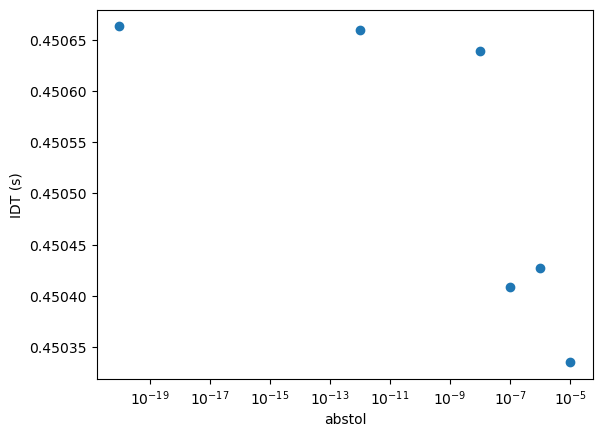

In [8]:
plt.figure()
plt.scatter(abstols, IDTs)
plt.xscale("log")
plt.xlabel("abstol")
plt.ylabel("IDT (s)")